In [ ]:
from optimization import *
import optimization
import sys
import os
sys.path.append("../python")

from optimization import generate_params, optimize_rbm, write_output, construct_hamiltonian_bonds_rotated
import rotation
import parseCouplings
sys.path.append("../Netket")

output_folder = "../data/data_random_rotated_rbm"
os.makedirs(output_folder, exist_ok=True)

input_file = "../python/couplings69.csv"
Jijs, hs, bondss = parseCouplings.parseCouplings(input_file)

n_samples = 100

In [105]:
import numpy as np
from scipy.linalg import expm
from scipy.optimize import minimize

sx = np.array([[0,1],[1,0]], dtype=complex)
sy = np.array([[0,-1j],[1j,0]], dtype=complex)
sz = np.array([[1,0],[0,-1]], dtype=complex)
def get_U_single(alpha, beta, gamma):
    # Use sx, sy, sz from notebook
    return expm(-1j*gamma*sz) @ expm(-1j*beta*sy) @ expm(-1j*alpha*sx)

def apply_local_rotation_to_state(psi, U_single, N, d=2):
    # psi: vector shape (d**N,)
    # U_single: (d,d)
    # we assume last index is site 0 (fastest varying). Change reshape order if needed.
    psi_t = psi.reshape((d,)*N)                    # tensor shape (d,d,...,d)
    # apply U to each site using tensordot, looping over sites
    for site in range(N):
        # move axis 'site' to front, apply U, move back
        psi_t = np.moveaxis(psi_t, site, 0)       # bring current site to axis 0
        psi_t = np.tensordot(U_single, psi_t, axes=[1,0])  # result shape (d, ... )
        psi_t = np.moveaxis(psi_t, 0, site)       # put axis back
    return psi_t.reshape(-1)

def get_rotation_objective(psi_initial, psi_target = None):
    if psi_target is None:
        psi_target = np.ones_like(psi_initial)/np.sqrt(len(psi_initial))
    N = int(np.log2(len(psi_target)))
    def objective(params):
        alpha, beta, gamma = params
        U1 = get_U_single(alpha, beta, gamma)
        # U1 = rotation_unitary_rpy(alpha, beta, gamma)
        # Rotate psi_max_ipr_arr and compare to psi_min_ipr_arr
        psi_rot = apply_local_rotation_to_state(psi_initial, U1, N, d=2)
        # Use negative overlap as loss
        overlap = np.abs(np.vdot(psi_target, psi_rot)) / (np.linalg.norm(psi_rot) * np.linalg.norm(psi_target))
        return -overlap
    return objective

def minimize_brute_force(objective, ranges, Ns=10):
    from itertools import product
    grid = [np.linspace(r[0], r[1], Ns) for r in ranges]
    best_params = None
    best_value = np.inf
    for params in product(*grid):
        value = objective(params)
        if value < best_value:
            best_value = value
            best_params = params
    return best_params, best_value
# import scipy
# result = minimize_brute_force(get_rotation_objective(exact_ground_state), [(-np.pi, np.pi)]*3, Ns=5)
# result = scipy.optimize.brute(get_rotation_objective(exact_ground_state), [(-np.pi, np.pi)]*3, Ns=30)

H_idx = 55

H_ran = construct_hamiltonian_bonds(Jijs[H_idx], hs[H_idx], bondss[H_idx])
H = H_ran

exact_ground_energy, exact_ground_state = nk.exact.lanczos_ed(H, k=1, compute_eigenvectors=True)
exact_ground_state = exact_ground_state[:,0]
exact_ground_state

result = minimize(get_rotation_objective(exact_ground_state), x0=[0,0,0], bounds=[(-np.pi, np.pi)]*3)
alpha_opt, beta_opt, gamma_opt = result.x
print("Optimal angles (alpha, beta, gamma):", alpha_opt, beta_opt, gamma_opt)
print("Max overlap:", -result.fun)

Optimal angles (alpha, beta, gamma): 0.04771956348397017 -1.2718618175283318 -0.3139044564902169
Max overlap: 0.9369169597905959


In [113]:
# Evaluate the objective at zero rotation angles
-get_rotation_objective(exact_ground_state)([0, 0, 0])

np.float64(0.0005762578458908903)

In [ ]:
def construct_hamiltonian_bonds_unitary(Jijalphabeta, h, bonds, U):
    N = h.shape[0]
    hilbert = nk.hilbert.Spin(s=0.5, N=N)

    Udagger = U.conj().T

    # Pauli matrices as numpy arrays
    pauli_matrices = [sx, sy, sz]
    # Rotated Pauli matrices
    pauli_rotated = [U @ p @ Udagger for p in pauli_matrices]

    # Define local operators using the rotated matrices
    def local_op(mat, site):
        return nk.operator.LocalOperator(hilbert, mat, [site])

    interaction_terms = [
        Jijalphabeta[bond, alpha, beta] * local_op(pauli_rotated[alpha], i) * local_op(pauli_rotated[beta], j)
        for (bond, (i, j)) in enumerate(bonds)
        for alpha in range(3)
        for beta in range(3)
        if np.abs(Jijalphabeta[bond, alpha, beta]) > 1e-12
    ]

    field_terms = [
        h[i, alpha] * local_op(pauli_rotated[alpha], i)
        for i in range(N)
        for alpha in range(3)
        if np.abs(h[i, alpha]) > 1e-12
    ]

    ha = sum(interaction_terms, nk.operator.LocalOperator(hilbert)) + sum(field_terms, nk.operator.LocalOperator(hilbert))
    return ha
H_ran_rot = construct_hamiltonian_bonds_unitary(Jijs[H_idx], hs[H_idx], bondss[H_idx], get_U_single(alpha_opt, beta_opt, gamma_opt))

In [115]:
H_ran_rot = construct_hamiltonian_bonds_unitary(Jijs[H_idx], hs[H_idx], bondss[H_idx], np.eye(2))
en_0, = nk.exact.lanczos_ed(H_ran, k=1, compute_eigenvectors=False)
en_1, = nk.exact.lanczos_ed(H_ran_rot, k=1, compute_eigenvectors=False)
en_0, en_1

(np.float64(-53.95400024351896), np.float64(-53.95400024351935))

In [ ]:
params_0 = generate_params(
    alpha=1,
    seed=1234,
    learning_rate=3e-2,
    n_iter=300,
    show_progress=True,
    out=f"../data/data_test_rot/rbm_optimization_ran_{H_idx}",
    overwrite=True,
)
output_file = params_0["out"] + ".log"

out = optimize_rbm(H_ran, params_0)
write_output(H_ran, out, params_0)

  0%|          | 0/300 [00:00<?, ?it/s]

In [109]:
params = generate_params(
    alpha=1,
    seed=1234,
    learning_rate=3e-2,
    n_iter=300,
    show_progress=True,
    out=f"../data/data_test_rot/rbm_optimization_opt_{H_idx}",
)
output_file = params["out"] + ".log"

out = optimize_rbm(H_ran_rot, params)
write_output(H_ran_rot, out, params)

  0%|          | 0/300 [00:00<?, ?it/s]

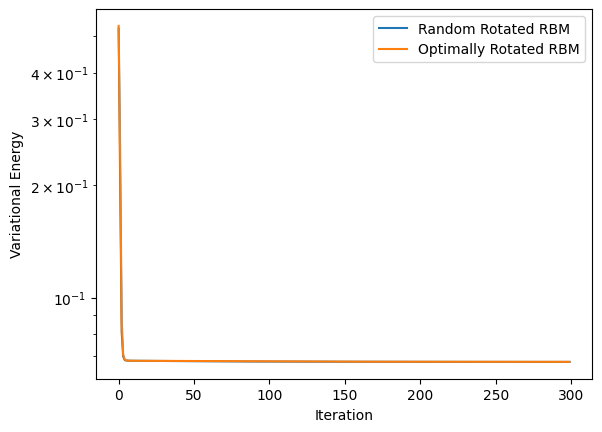

In [118]:
import h5py
import matplotlib.pyplot as plt

def h5read(filename,key):
	with h5py.File(filename, "r") as f:
		# Try both possible keys for energy
		if key in f:
			return f[key][:]
		raise KeyError("key not found in file.")

en_var_ref = h5read(params_0["out"] + ".h5","en_var_steps") 
en_var_ref_rel = (en_var_ref - exact_ground_energy) / np.abs(exact_ground_energy)

plt.plot(en_var_ref_rel, label="Random Rotated RBM")
en_var_opt = h5read(params["out"] + ".h5","en_var_steps")
en_var_opt_rel = (en_var_opt - exact_ground_energy) / np.abs(exact_ground_energy)
plt.plot(en_var_opt_rel, label="Optimally Rotated RBM")
plt.xlabel("Iteration")
plt.ylabel("Variational Energy")
plt.yscale("log")
plt.legend()
plt.show()

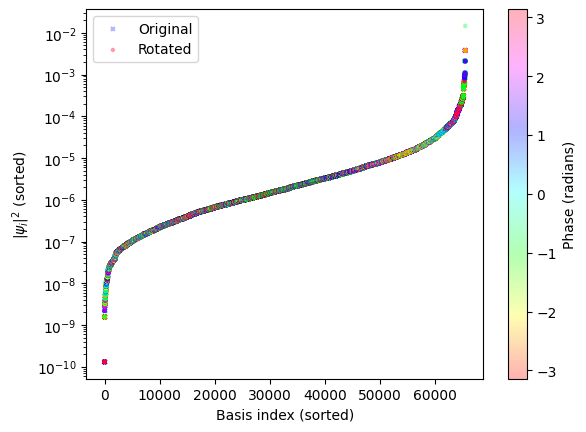

In [ ]:
psi_unrot = h5read(params_0["out"] + ".h5","psi_0")

psi_rot_opt = h5read(params["out"] + ".h5","psi_0")

sorted_indices = np.argsort(np.abs(psi_unrot)**2)
sorted_amplitudes = np.abs(psi_unrot)[sorted_indices]**2
sorted_phases = np.angle(psi_unrot)[sorted_indices]

plt.scatter(
    range(len(sorted_amplitudes)),
    sorted_amplitudes,
    c=sorted_phases,
    cmap='hsv',
    label='Original',
    marker='x',
    s=8,
    alpha=0.3
)

sorted_indices = np.argsort(np.abs(psi_rot_opt)**2)
sorted_amplitudes = np.abs(psi_rot_opt)[sorted_indices]**2
sorted_phases = np.angle(psi_rot_opt)[sorted_indices]

plt.scatter(
	range(len(sorted_amplitudes)),
	sorted_amplitudes,
	c=sorted_phases,
	cmap='hsv',
	label='Rotated',
	marker='o',
	s=5,
	alpha=0.3
)


# plt.plot(np.sort(np.abs(psi_a)**2), label='Target', marker='o', lw=0.05, markersize=3, alpha=0.8, color='black')
plt.yscale('log')
plt.colorbar(label='Phase (radians)')#
plt.ylabel(r'$|\psi_i|^2$ (sorted)')
plt.xlabel('Basis index (sorted)')
plt.legend()